In [ ]:
# ATTENTION! Only after import ipem_auditory_model fails, 
# recompile the C file using the code in this cell, and move the files according to the setup comments.
!pip install cython
import cython
%cd C:/Users/w1881/Desktop/github/jlmt_python
!python setup.py build_ext --inplace

In [1]:
import os
import sys
## Change the path to the package location on your computer.
os.chdir(r"C:\Users\w1881\Desktop\github\jlmt_python")
print(os.getcwd())#Setting up the work environment
sys.path.append(r"C:\Users\w1881\Desktop\github\jlmt_python\src")
sys.path.append(r"C:\Users\w1881\Desktop\github\jlmt_python\src\jlmt_py")#Add the jlmt_py package to the path


C:\Users\w1881\Desktop\github\jlmt_python


In [2]:
from jlmt_py import load_audio

audio_path = r"C:\Users\w1881\Desktop\github\jlmt_python\test_sound\test1.wav"   # Your own music file path


y, sr = load_audio(audio_path)
print(f"Audio loaded: {y.shape}, sample rate: {sr}")

Audio loaded: (1404144,), sample rate: 44100


Start of calc_ani...
...end of calc_ani.


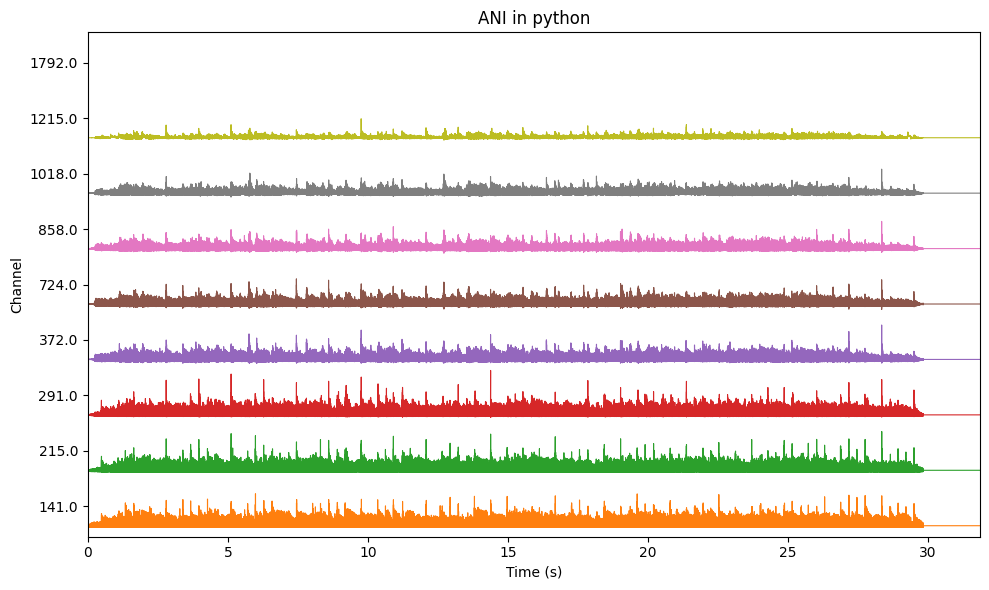

In [3]:
from jlmt_py import calc_ani, plot_multi_channel

ani, ani_freq, freqs = calc_ani(y, sr)
plot_multi_channel(
   ani,
   sample_freq=ani_freq,
   title='ANI in python',
   xlabel='Time (s)',
   ylabel='Channel',
   font_size=12,
   channel_labels=freqs,
   channels=[1, 3, 5, 7, 14, 16, 18, 20, 24],
   plot_type=2
)

In [4]:
from jlmt_py import calc_pp, apply_attenuation
pp, out_fs, out_periods, fani, delay = calc_pp(ani, ani_freq)
final_pp = apply_attenuation(pp, atten_type='ipem_squash_hf')

print(final_pp.shape)


(105, 835)


In [5]:
from jlmt_py import leaky_integrate
li = leaky_integrate(final_pp, out_fs, half_decay_time=0.1)

print(li.shape)

(105, 835)


In [6]:
from jlmt_py import load_som, calc_tonal_space
som_path = "./map/map_10-Dec-2006_16_18.mat"

weights, msize = load_som(som_path)
print("weights shape (n_units, n_features):", weights.shape)
ts_map_3d, ts_map_2d = calc_tonal_space(li, weights, msize)

print(f"3D TS Map shape: {ts_map_3d.shape}")
print(f"2D TS Map shape: {ts_map_2d.shape}")

weights shape (n_units, n_features): (768, 105)
Computing Tonal Space projection...
...Done. TS activation map shape: (24, 32, 835)
3D TS Map shape: (24, 32, 835)
2D TS Map shape: (768, 835)


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from scipy.io import loadmat

# 1. Animation data loading
def load_mode_map_data(mode_map_path):
    """Reads .mat files and extracts boundary lines and labels."""
    print(f"Reading file: {mode_map_path} ...")
    try:
        # Setting struct_as_record=False is extremely important; it ensures that the struct is loaded as an object instead of a NumPy void.
        mat = loadmat(mode_map_path, squeeze_me=True, struct_as_record=False)
    except FileNotFoundError:
        print(f"Error: File not found {mode_map_path}")
        return None, None, None, (24, 32)

    # --- A. bound_params ---
    bound_params = mat.get('bound_params', [])

    # --- B. labels ---
    labels = []
    raw_labels = None
    if 'new_label_array' in mat:
        raw_labels = mat['new_label_array']
    elif 'label_array' in mat:
        raw_labels = mat['label_array']
    
    if raw_labels is not None:
        if isinstance(raw_labels, np.ndarray):
            labels = [str(x).strip() for x in raw_labels.flatten() if x]
        else:
            labels = [str(raw_labels).strip()] if isinstance(raw_labels, str) else raw_labels
            
    # --- C. label_idxs ---
    label_idxs = []
    if 'label_idxs' in mat:
        raw_idxs = mat['label_idxs']
        if np.ndim(raw_idxs) == 0: raw_idxs = [raw_idxs]
        # MATLAB is 1-based，Python is 0-based，so it should -1
        label_idxs = np.array(raw_idxs, dtype=int) - 1

    # --- D. sM.topol.msize ---
    rows, cols = 24, 32
    if 'sM' in mat:
        try:
            sM = mat['sM']
            if hasattr(sM, 'topol'):
                topol = sM.topol
                if hasattr(topol, 'msize'):
                    dims = topol.msize
                    rows, cols = int(dims[0]), int(dims[1])
        except:
            pass 
    
    print(f"Data loaded: bound {len(bound_params)}, label {len(labels)}, size {rows}x{cols}")
    return bound_params, labels, label_idxs, (rows, cols)
import numpy as np

def som_vis_coords(lattice, msize):
    """
    Python implementation of som_vis_coords.m
    
    Parameters:
        lattice (str): 'rect' or 'hexa'
        msize (tuple/list): [rows, cols] e.g., [24, 32]
        
    Returns:
        unit_coords (np.ndarray): (n_units, 2) matrix of coordinates [x, y]
                                  Matches MATLAB's output (1-based indexing logic)
    """
    rows, cols = int(msize[0]), int(msize[1])
    munits = rows * cols
    
    # --- 1. Rectangular ---
    x_coords = np.repeat(np.arange(1, cols + 1), rows)
    y_coords = np.tile(np.arange(1, rows + 1), cols)
    
    unit_coords = np.column_stack((x_coords, y_coords))
    
    # --- 2. Hexagonal Shift ---
    if lattice == 'hexa':
        is_even_row = (unit_coords[:, 1] % 2 == 0)
        unit_coords[is_even_row, 0] += 0.5
    
    return unit_coords

# ==========================================
# 2. Generate video
# ==========================================

mode_map_file = r"C:/Users/w1881/Desktop/github/jlmt_python/map/toract_mode_map_20130118.mat"
output_filename = 'tonal_space_final.mp4'
n_frames = ts_map_3d.shape[2] 
frame_step_sec = 0.04         
fps = 1.0 / frame_step_sec
rows, cols, _ = ts_map_3d.shape

bound_params, labels, label_idxs, map_dims = load_mode_map_data(mode_map_file)
map_rows, map_cols = map_dims
coords_map = som_vis_coords('rect', map_dims) 
coords_map_python = coords_map - 1 + 0.5 

fig = plt.figure(figsize=(10, 8), dpi=100)
canvas = FigureCanvasAgg(fig)
ax = fig.add_subplot(111)

canvas.draw()
w, h = canvas.get_width_height()

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_filename, fourcc, fps, (w, h))

vmin = np.percentile(ts_map_3d, 1)
vmax = np.percentile(ts_map_3d, 99)

print(f"Start generating video, totaling {ts_map_3d.shape[2]} frames....")

for frame_num in range(ts_map_3d.shape[2]):
    ax.clear()

    im = ax.imshow(ts_map_3d[:, :, frame_num], origin='lower', cmap='jet', 
                   aspect='equal', vmin=vmin, vmax=vmax,
                   extent=[0, cols, 0, rows]) 

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)

    if len(labels) > 0 and len(label_idxs) > 0:
        for i, unit_idx in enumerate(label_idxs):
            if i >= len(labels): break
            
            if unit_idx < len(coords_map_python):
                x_pos = coords_map_python[unit_idx, 0]
                y_pos = coords_map_python[unit_idx, 1]
                
                ax.text(x_pos, y_pos, labels[i], color='black', 
                        ha='center', va='center', fontweight='bold', fontsize=12)

    if frame_num == 0:
        cbar = fig.colorbar(im, ax=ax, label="Activation Value")

    canvas.draw()
    buf = canvas.buffer_rgba()
    img_array = np.asarray(buf)
    # RGBA -> BGR
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGBA2BGR)
    
    out.write(img_bgr)
    
    if frame_num % 50 == 0:
        print(f"Written to: {frame_num} frames")

out.release()
plt.close(fig)
print(f"The video has been saved as: {output_filename}")

Reading file: C:/Users/w1881/Desktop/github/jlmt_python/map/toract_mode_map_20130118.mat ...
Data loaded: bound 7, label 24, size 24x32
Start generating video, totaling 835 frames....
Written to: 0 frames
Written to: 50 frames
Written to: 100 frames
Written to: 150 frames
Written to: 200 frames
Written to: 250 frames
Written to: 300 frames
Written to: 350 frames
Written to: 400 frames
Written to: 450 frames
Written to: 500 frames
Written to: 550 frames
Written to: 600 frames
Written to: 650 frames
Written to: 700 frames
Written to: 750 frames
Written to: 800 frames
The video has been saved as: tonal_space_final.mp4


In [11]:
import numpy as np

def smooth_temporal_motion(frames, alpha=0.2):
    """
    frames: (H, W, T)
    alpha: smoothing strength for motion (0.1–0.3 recommended)
    return: smoothed frames with motion preserved
    """

    H, W, T = frames.shape
    frames_smooth = np.zeros_like(frames)

    # 1. Copy first frame
    frames_smooth[:, :, 0] = frames[:, :, 0]

    # 2. Compute deltas
    deltas = frames[:, :, 1:] - frames[:, :, :-1]

    # 3. EMA smooth deltas
    deltas_smooth = deltas.copy()
    for t in range(1, deltas.shape[2]):
        deltas_smooth[:, :, t] = alpha * deltas[:, :, t] + (1 - alpha) * deltas_smooth[:, :, t-1]

    # 4. Reconstruct smoothed frames
    for t in range(1, T):
        frames_smooth[:, :, t] = frames_smooth[:, :, t-1] + deltas_smooth[:, :, t-1]

    return frames_smooth

ts_map_3d = smooth_temporal_motion(ts_map_3d, alpha=0.2)